In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
import seaborn as sns
import os
import cv2

In [ ]:
vgg = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DAEN690/VGG16_2/VGG16_2.h5')
# vgg.summary()

In [ ]:
last_conv_layer = vgg.get_layer("block5_conv3")
last_conv_layer_model = tf.keras.Model(vgg.inputs, last_conv_layer.output)
# last_conv_layer_model.summary()

In [ ]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
y = vgg.get_layer("block5_pool")(x)
y = Flatten()(y)
# y = Dense(4096, activation='relu')(y)
y = Dense(3, activation='softmax')(y)
classifier_model = tf.keras.Model(classifier_input, y)
# classifier_model.summary()

In [ ]:
def gradCam(image):  
  with tf.GradientTape() as tape:
      inputs = image[np.newaxis, ...]
      last_conv_layer_output = last_conv_layer_model(inputs)
      tape.watch(last_conv_layer_output)
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
      last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # Average over all the filters to get a single 2D array
  gradcam = np.mean(last_conv_layer_output, axis=-1)
  # Clip the values (equivalent to applying ReLU) and then normalise the values
  gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
  gradcam = cv2.resize(gradcam, (224, 224))

  plt.imshow(image)
  plt.imshow(gradcam, alpha=0.5)

In [ ]:
def guidedGradCam(image):  
  with tf.GradientTape() as tape:
      last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
      tape.watch(last_conv_layer_output)
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
  last_conv_layer_output = last_conv_layer_output[0]

  guided_grads = (
      tf.cast(last_conv_layer_output > 0, "float32")
      * tf.cast(grads > 0, "float32")
      * grads
  )

  pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
  guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

  for i, w in enumerate(pooled_guided_grads):
      guided_gradcam += w * last_conv_layer_output[:, :, i]

  guided_gradcam = cv2.resize(guided_gradcam.numpy(), (224, 224))

  guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
  guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
      guided_gradcam.max() - guided_gradcam.min()
  )

  # plt.imshow(image)
  # plt.imshow(guided_gradcam, alpha=0.5)

  @tf.custom_gradient
  def guided_relu(x):
      def grad(dy):
          return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

      return tf.nn.relu(x), grad

  class GuidedBackprop:
      def __init__(self, model, layer_name: str):
          self.model = model
          self.layer_name = layer_name
          self.gb_model = self.build_guided_model()

      def build_guided_model(self):
          gb_model = tf.keras.Model(
              self.model.inputs, self.model.get_layer(self.layer_name).output
          )
          layers = [
              layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
          ]
          for layer in layers:
              if layer.activation == tf.keras.activations.relu:
                  layer.activation = guided_relu
          return gb_model

      def guided_backprop(self, image: np.ndarray):
          with tf.GradientTape() as tape:
              inputs = tf.cast(image, tf.float32)
              tape.watch(inputs)
              outputs = self.gb_model(inputs)
          grads = tape.gradient(outputs, inputs)[0]
          return grads

  gb = GuidedBackprop(vgg, "block5_conv3")

  saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
  saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

  saliency_map -= saliency_map.mean()
  saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
  saliency_map *= 0.25
  saliency_map += 0.5
  saliency_map = np.clip(saliency_map, 0, 1)
  saliency_map *= (2 ** 8) - 1
  saliency_map = saliency_map.astype(np.uint8)

  plt.imshow(saliency_map)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/DAEN690/misclassification/Old/Binary"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})

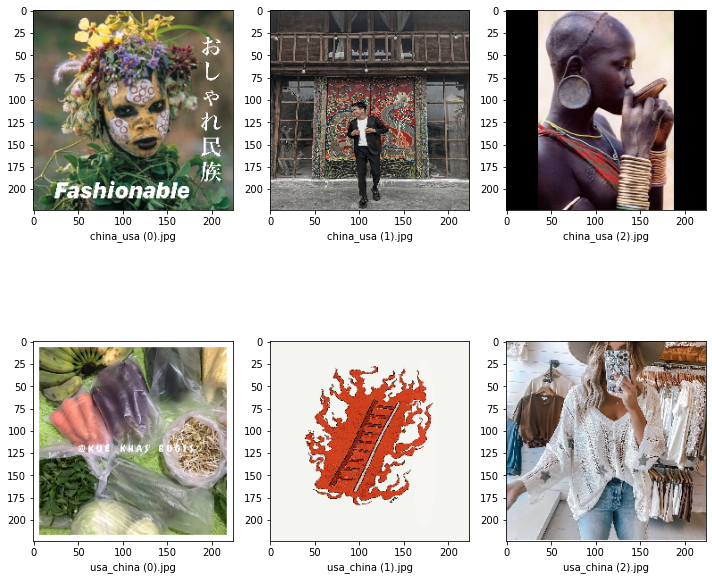

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

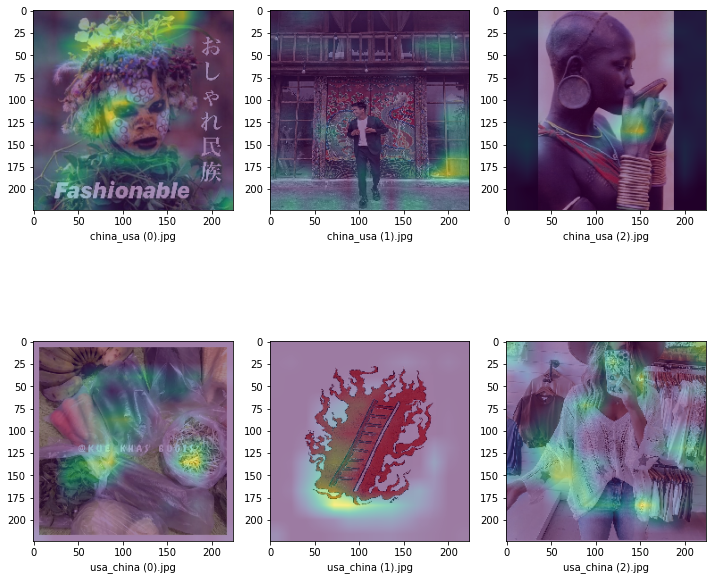

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    gradCam(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


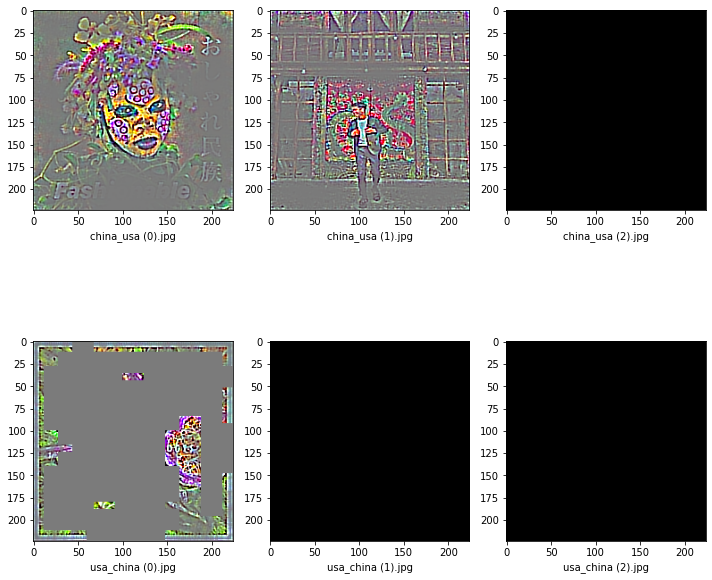

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    guidedGradCam(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/DAEN690/misclassification/New/Binary"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})

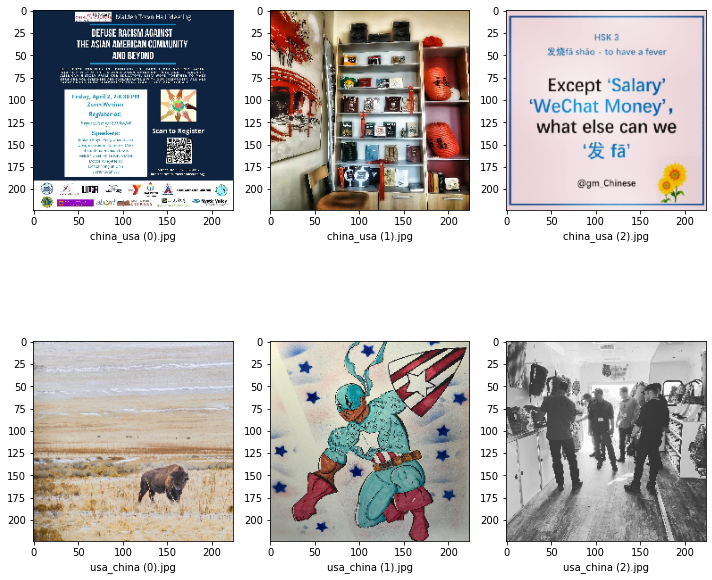

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

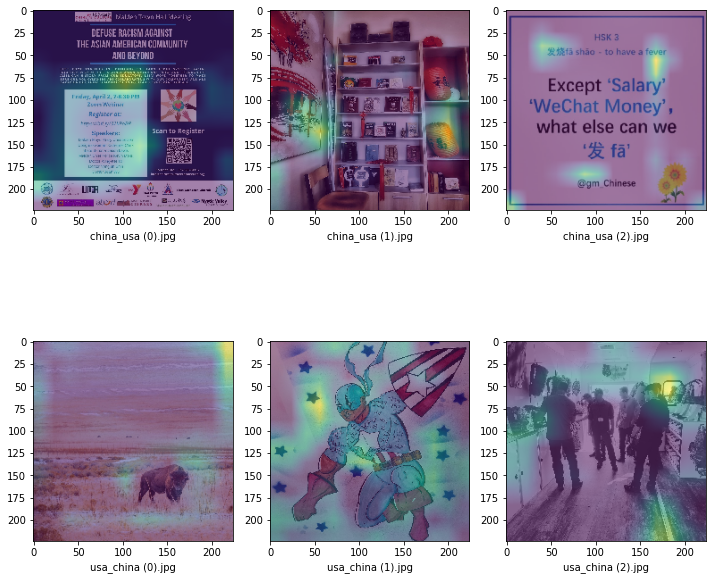

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    gradCam(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

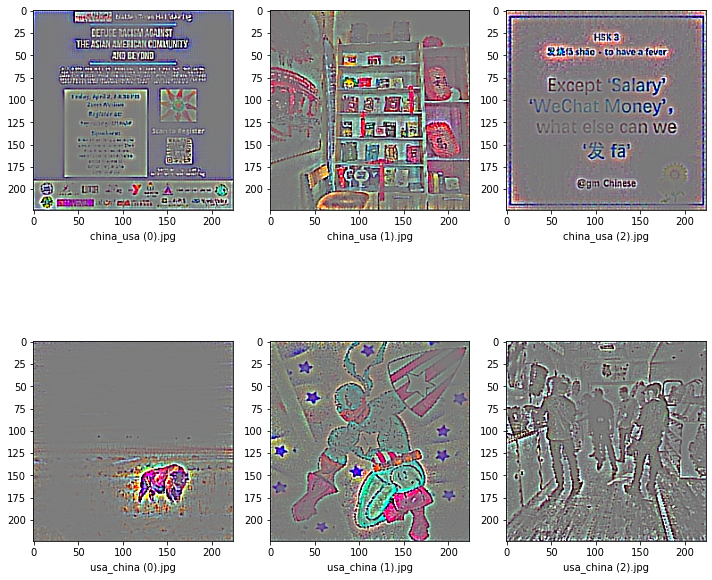

In [ ]:
plt.figure(figsize=(10, 10))
for index, row in df.iterrows():
    filename = row['filename']
    # pred = row['pred']
    img = np.array(load_img(path + "/" + filename, target_size=(224,224)))
    plt.subplot(2, 3, index+1)
    guidedGradCam(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()